# Asssignment 1 for Advanced Bayesian Methods

## Q1 - (g)

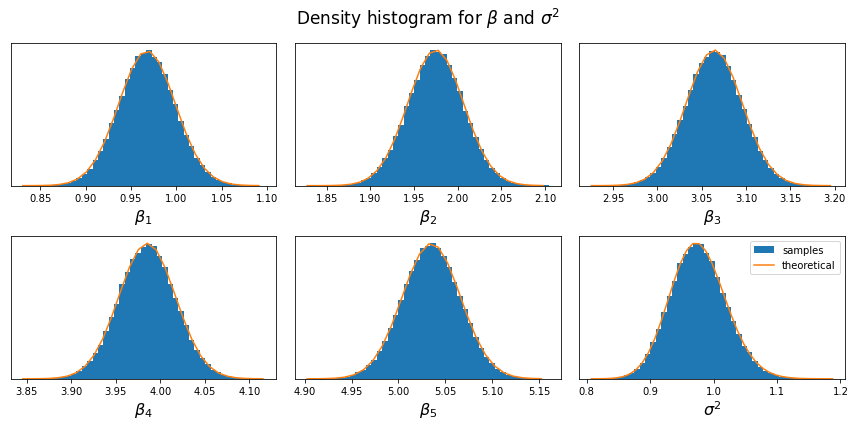

In [5]:
### library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from scipy.stats import chi2, norm
from numpy.linalg import inv
from scipy.special import loggamma

warnings.filterwarnings('ignore')
plt.rcParams['figure.facecolor'] = 'white'
np.set_printoptions(suppress=True)

## pdf of scaled noncentral t distribution
def scaled_noncentral_t(x, mu, sigma, nu):
    prob = np.exp(loggamma((nu + 1) / 2) - loggamma(nu / 2) - np.log(np.sqrt(nu * np.pi) * sigma)) * \
        (1 + 1 / nu * ((x - mu) / sigma)**2)**(-(nu + 1) / 2)
    return prob

## pdf of scaled inverse chi2 distribution
def scaled_inverse_chi2(x, nu, tau2):
    log = (nu / 2) * np.log(nu * tau2 / 2) - loggamma(nu / 2) - (nu / 2 +1) * np.log(x) - (nu * tau2 / (2 * x))
    return np.exp(log)

## draw sigma2 sample given y
def Draw_sigma2_sample(X, hyper, iter):
    """ Draw sigma2 from p(sigma2 | y) """

    # parameters
    n, p = X.shape
    df = hyper['nu0'] + n                                 # df of Scaled-Inv-chi2
    SS_inv = inv(np.matmul(X.T, X) + hyper['K0'])
    inside = np.eye(n) - np.matmul(X, np.matmul(SS_inv, X.T))
    SSE = np.matmul(y.T, np.matmul(inside, y))
    tau2 = (hyper['nu0'] * hyper['sigma2_0'] + SSE) / df  # scaling paramter of Scaled-Inv-chi2

    # for multivariate t
    cov = (hyper['nu0'] * hyper['sigma2_0'] + SSE) / df * SS_inv    
    
    # sampling sigma2
    sigma2_samples = np.zeros(iter)
    for i in range(iter):
        # 1. Draw chi2 random sample
        w = chi2.rvs(df, size=1)
        # 2. Scaled and inverse
        sigma2 = df * tau2 / w  # scaled inverse Chi2 r.v.
        sigma2_samples[i] = sigma2

    return sigma2_samples, df, tau2, cov

## draw beta conditional on sigma2, y
def Draw_beta_sample(X, y, sigma2):
    """ Draw beta from p(beta | sigma2, y) conditional on sigma2 """

    # parameters
    n, p = X.shape
    SS = np.matmul(X.T, X) + hyper['K0']
    beta_hat = np.matmul(inv(SS), np.matmul(X.T, y))
    iter = len(sigma2)
    
    # sampling beta conditional on sigma2
    beta_samples = np.zeros(shape=(iter, p))
    for i in range(iter):
        beta_cov = sigma2[i] * inv(np.matmul(X.T, X) + hyper['K0'])

        ## 1. Cholesky decomposition
        A = np.linalg.cholesky(beta_cov)  
        # Sanity check; np.sum(beta_cov.round(5) != np.matmul(A, A.T).round(5))

        ## 2. Draw standard normal random samples
        Z = np.random.normal(0, 1, p)
        beta_samples[i] = np.matmul(A, Z) + beta_hat
    
    return beta_samples, beta_hat


## 0. Initial setting
n = 1000; p = 5
true = dict({
    'beta': [1, 2, 3, 4, 5],
    'sigma': 1
})

# Conjugate prior that provide weak information
hyper = dict({
    'm0':0,
    'K0':np.eye(p) * 0.0001,
    'nu0': 0.0001,
    'sigma2_0':0.0001
})

## 1. Draw X from standard normal distribution
X = np.random.normal(0, 1, size=(n, p))

## 2. Generate y
# 1) Draw z_i from z ~ N(0, 1) (i = 1, ..., n) and Z = [z_1, ..., z_n] ~ MVN(0, I)
Z = np.random.normal(0, 1, n)

# 2) Transformation: y = Z + mu => y ~ MVN(mu, I)
y_mean = np.matmul(X, true['beta'])
y = Z + y_mean

## 3. Draw sigma2 
sigma2_samples, df, tau2, cov = Draw_sigma2_sample(X, hyper, 10**5)

## 4. Draw beta conditional on sigma2
beta_samples, beta_hat = Draw_beta_sample(X, y, sigma2_samples)

## 5. Plotting
plt.figure(figsize=(6*2, 3*2))

# 1) for beta
for i in range(X.shape[1]):
    plt.subplot(2, 3, i+1)
    plt.hist(beta_samples[:, i], density=True, bins=45, label='samples')

    # Marginal posterior of beta ~ multivariate t; t_df, t_cov, beta_hat
    grid = np.arange(min(beta_samples[:, i]), max(beta_samples[:, i]), 0.01)
    theoretical = scaled_noncentral_t(x=grid, mu=beta_hat[i], sigma = np.sqrt(cov.diagonal()[i]), nu = df)  
    plt.plot(grid, theoretical, label='theoretical')
    plt.xlabel(f'$\\beta_{i+1}$', fontsize=16)
    plt.yticks(())

# 2) for sigma2
plt.subplot(2, 3, 6)
plt.hist(sigma2_samples, density=True, bins=45, label='samples')

# Marginal posterior of sigma2 ~ scaled-inv-chi2; nu=df, tau2=tau2
grid = np.arange(min(sigma2_samples), max(sigma2_samples), 0.01)
theoretical = scaled_inverse_chi2(x=grid, nu=df, tau2=tau2)
plt.plot(grid, theoretical, label='theoretical')
plt.xlabel(f'$\\sigma^2$', fontsize=16)
plt.yticks(())

plt.legend()
plt.suptitle(f'Density histogram for $ \\beta$ and $ \\sigma^2$', fontsize=17)
plt.tight_layout()
plt.savefig('./hw1')
plt.show()